In [2]:
import matplotlib.pyplot as plt

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim, dim_decoder_input, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, dim)
        self.l1 = nn.Linear(dim, dim)
        self.l2 = nn.Linear(dim, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

In [4]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss


manager = Manager()
manager.prepare_data()
dims = [16, 32, 64, 128, 256, 512, 1024, 2048]
for dim in dims:
    manager.set_model(My_Encoder(dim, 4), My_Decoder(dim, 2))
    manager.train(calc_loss, epochs=30)
    manager.add_model(f'vae_{dim} 30')


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:36<00:00,  5.21s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:38<00:00,  5.28s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:37<00:00,  5.26s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:40<00:00,  5.37s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


Now, it is working on cuda:0.


100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


In [7]:
def compare(manager, names):
    fig, axs = plt.subplots(nrows=len(names), ncols=5, figsize=[20, 30])

    manager.swap_current_model(names[0])
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs[0], x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs[1], x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        for idx in range(2, len(names)):
            with torch.no_grad():
                manager.swap_current_model(names[idx])

                manager.model.to('cpu')
                manager.model.eval()

                h = manager.model.get_submodule("encoder")(x)
                mu = h[:, :2]
                x_hats = manager.model.get_submodule("decoder")(mu)
            for ax, img in zip(axs[idx], x_hats):
                ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
                ax.axis('off')
        
        break
    plt.tight_layout()

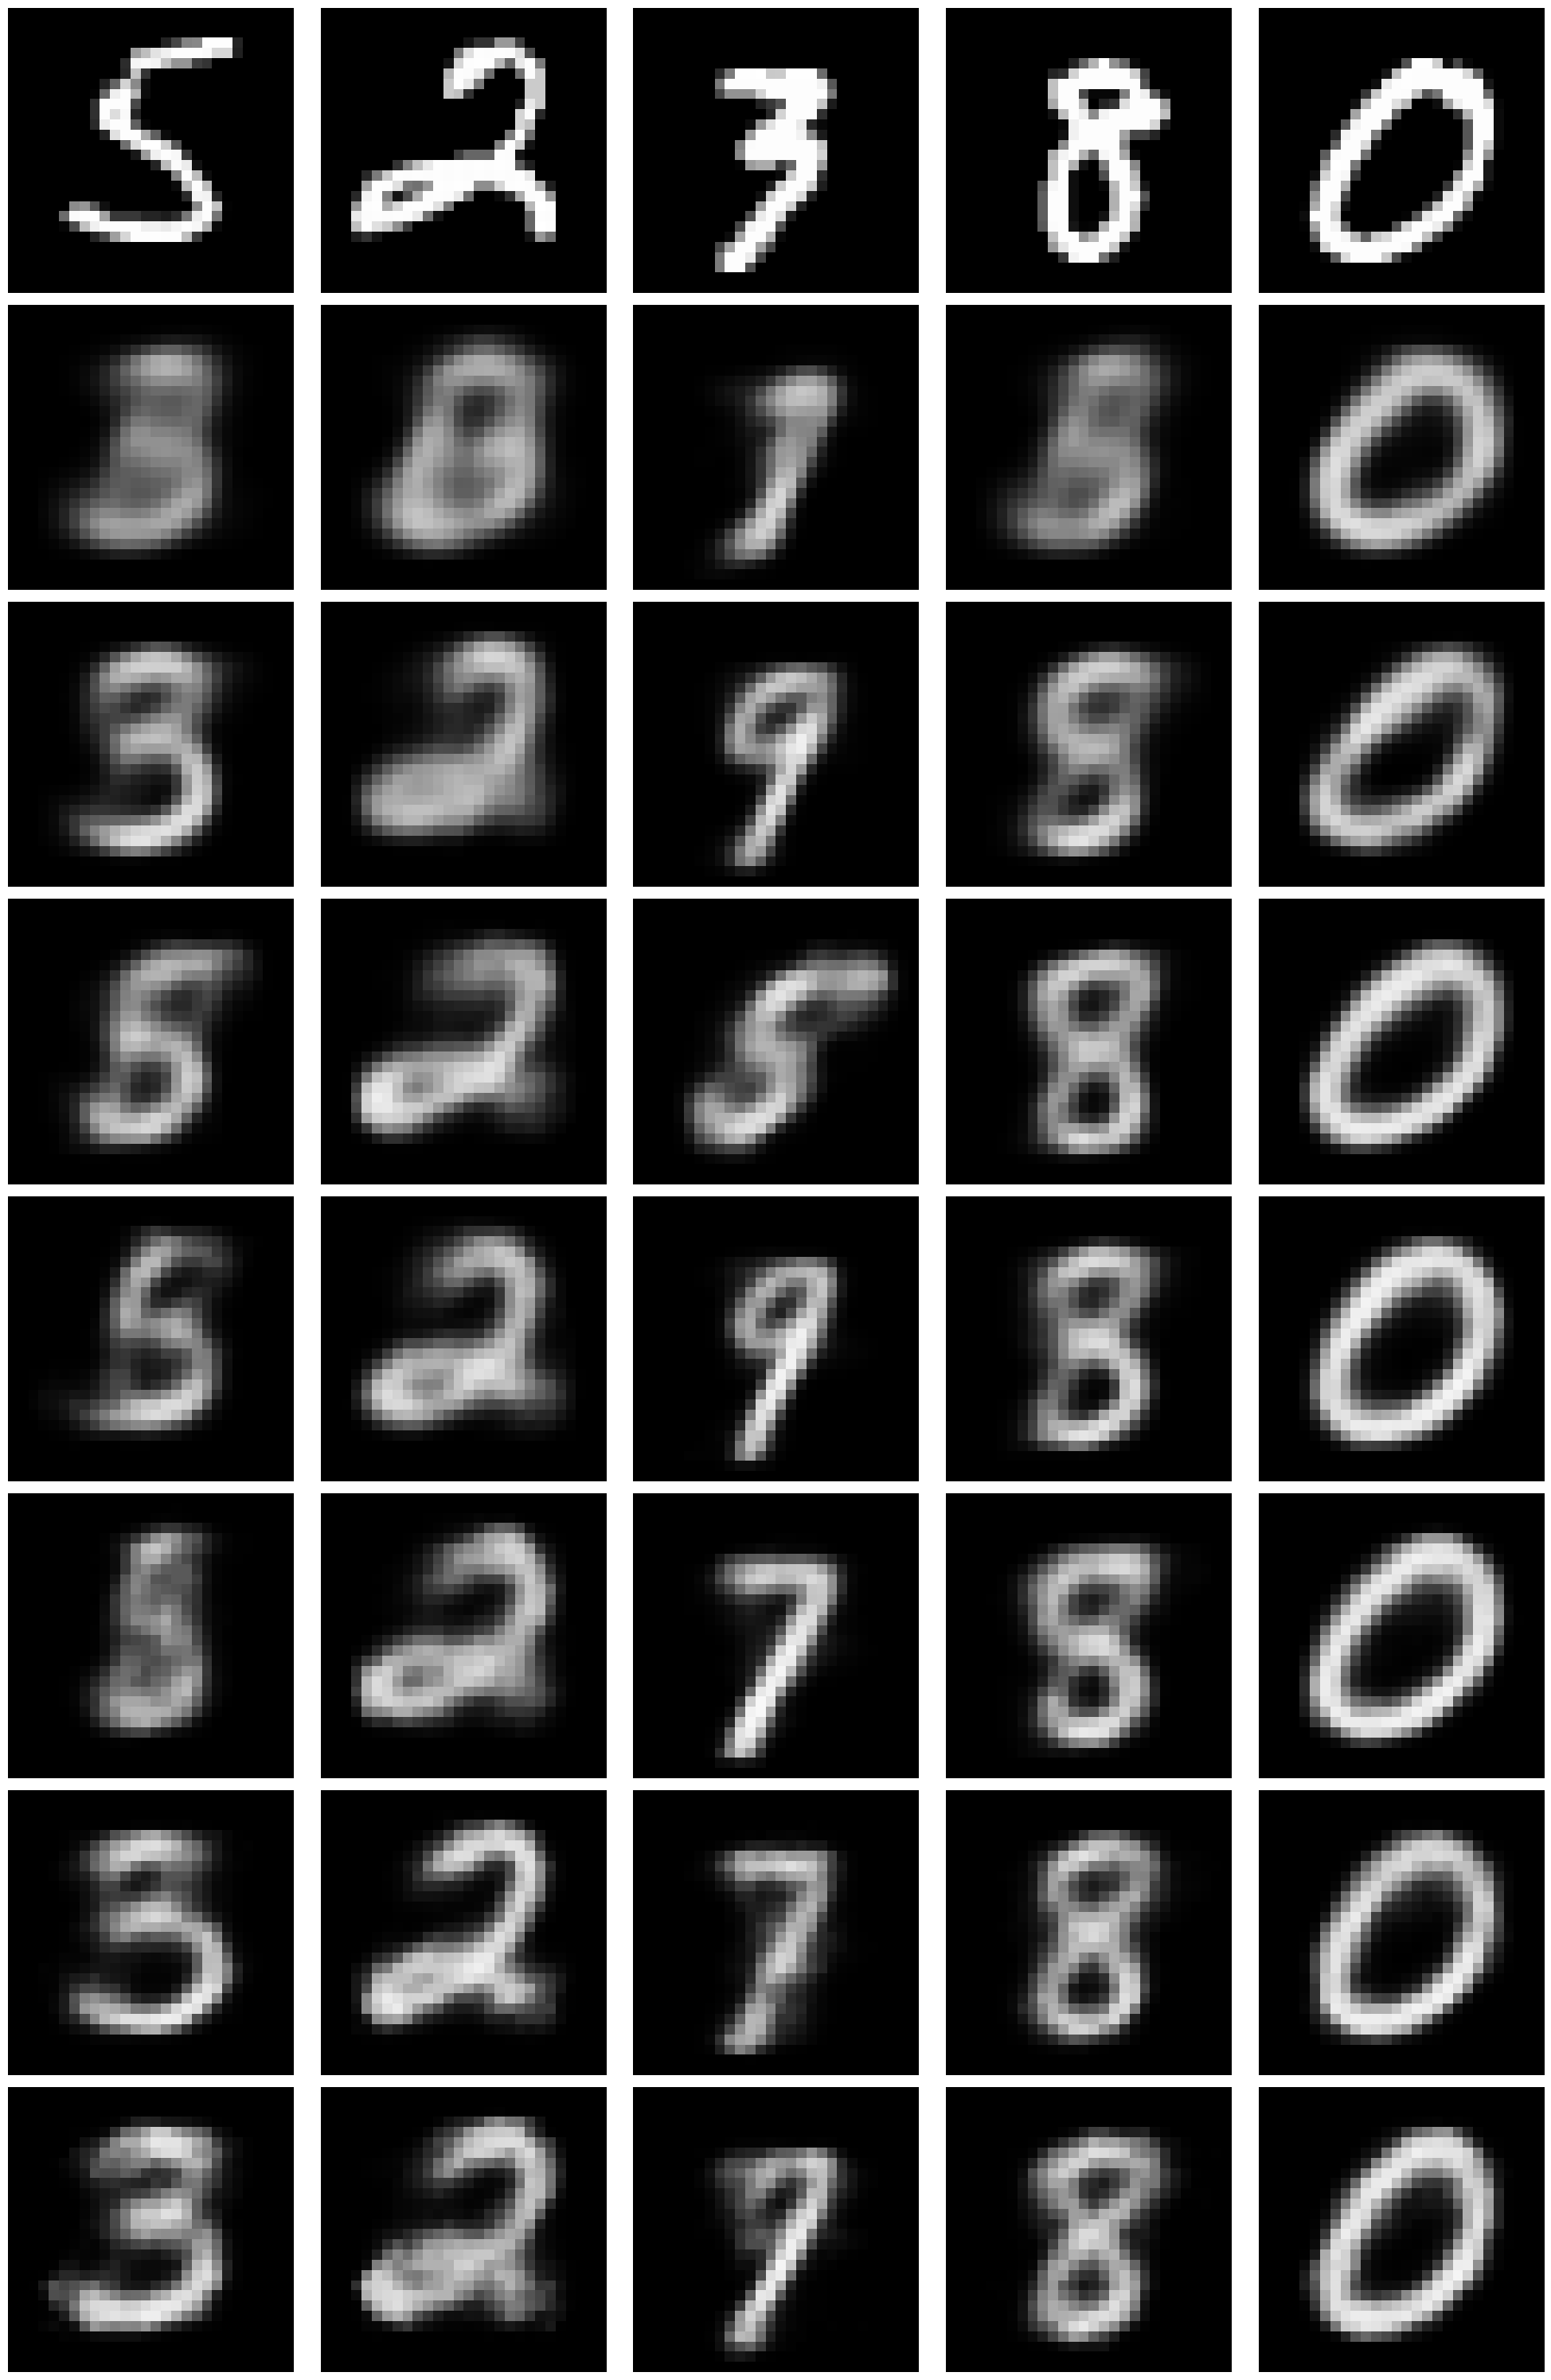

In [13]:
names = [f'vae_{dim} 30' for dim in dims]
compare(manager, names)

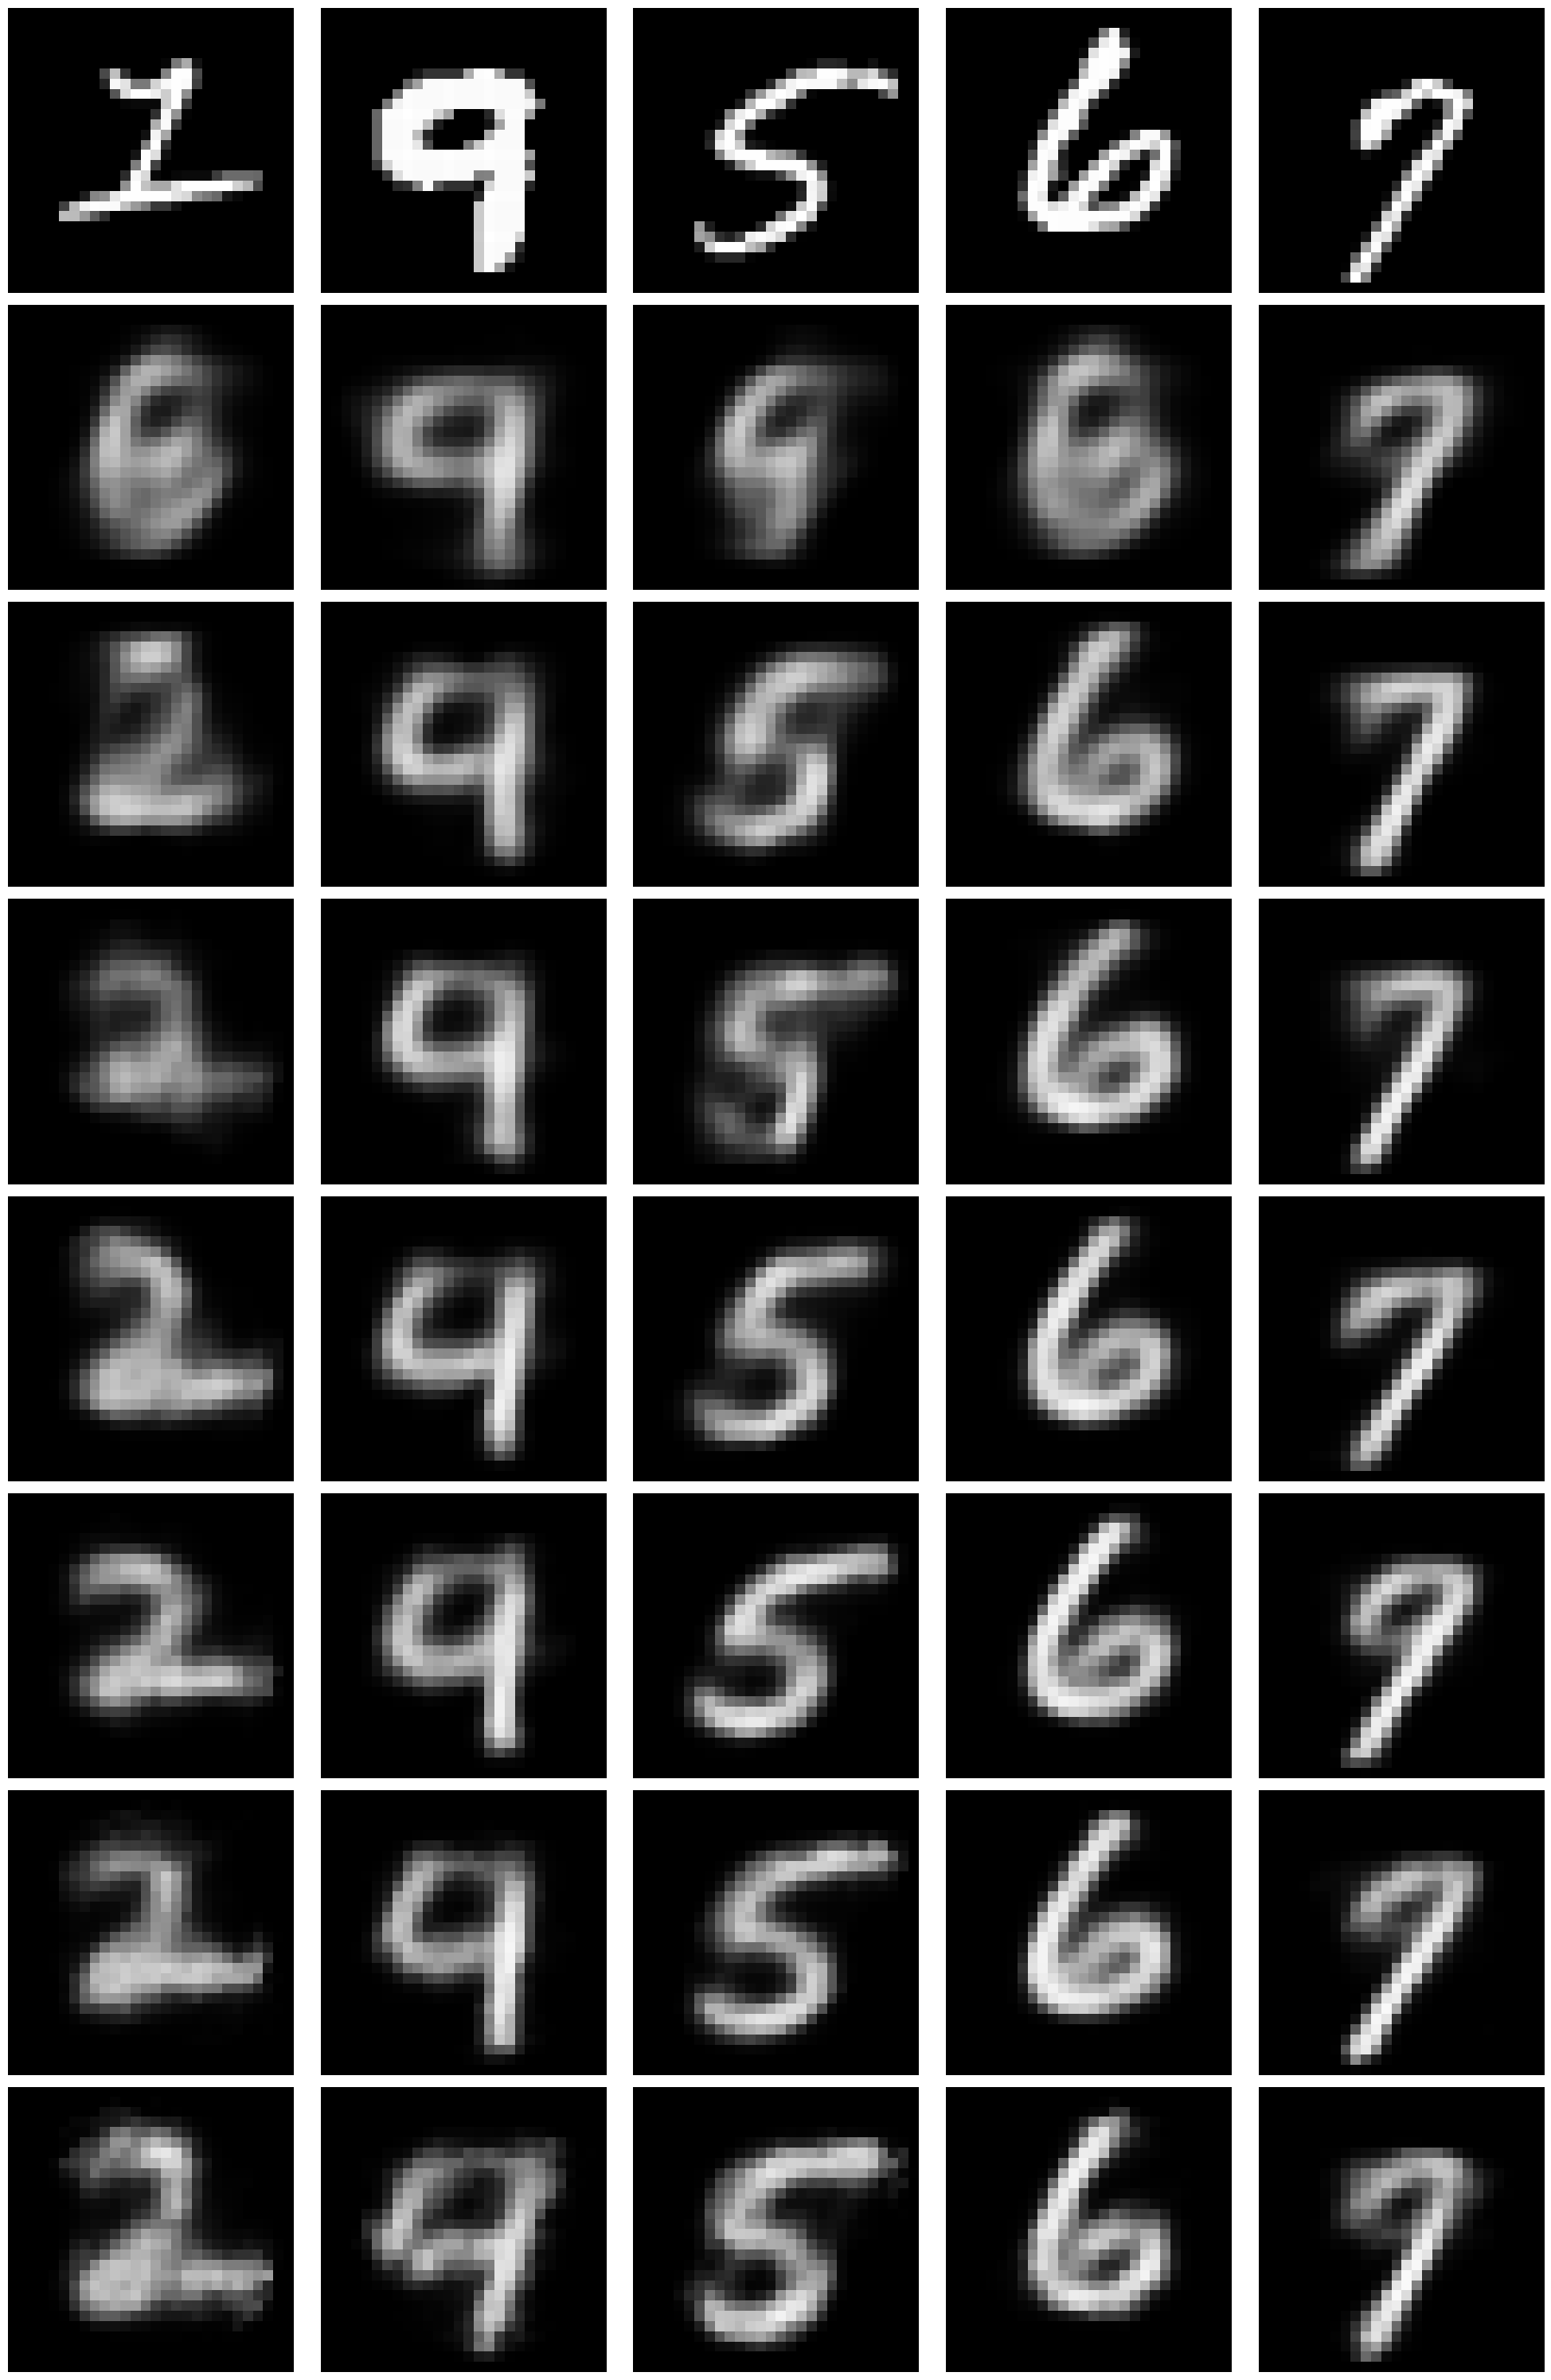

In [22]:
compare(manager, names)